In [42]:
from pathlib import Path
from collections import defaultdict

from Bio.Phylo.BaseTree import Tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes

In [43]:

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [44]:
REFERENCE_TREE_DIR = Path("data/lphy")
MAP_TREE_DIR = Path("data/map_validation")

In [45]:
def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        rbs += abs(branch_1 - branch_2)

    return rbs


def squared_rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    srbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        srbs += (branch_1 - branch_2)**2

    return srbs


def height_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    hs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if (node_1 := clades_to_node_1.get(clade)) and (node_2 := clades_to_node_2.get(clade)):
            hs += abs(node_1.height - node_2.height)
        elif node_1:
            hs += node_1.height - node_1.parent_height
        elif node_2:
            hs += node_2.height - node_2.parent_height

    return hs

In [46]:
1 & 3

1

In [47]:
def get_common_ancestor_clade(ref_clade: int, query_clades: list[int]) -> int:
    if ref_clade in query_clades:
        return ref_clade
    
    matching_clades = (
        query_clade
        for query_clade in query_clades
        if query_clade & ref_clade == ref_clade
    )
    return min(matching_clades, key=lambda x: x.bit_length())

def heights_error(query_tree: Tree, ref_tree: Tree) -> float:
    taxa_names = get_taxa_names(ref_tree)

    query_nodes, _ = get_observed_nodes([query_tree], taxa_names)
    ref_nodes, _ = get_observed_nodes([ref_tree], taxa_names)

    query_clades_to_node = {node.node_bitstring: node for node in query_nodes}
    ref_clades_to_node = {node.node_bitstring: node for node in ref_nodes}

    heights_error = 0.0

    for query_clade, node in query_clades_to_node.items():
        ref_clade = get_common_ancestor_clade(query_clade, list(ref_clades_to_node.keys()))
        
        heights_error += abs(node.height - ref_clades_to_node[ref_clade].height)

    return heights_error

In [48]:
map_trees_per_dataset: dict[str, list[Path]] = defaultdict(list)

for map_tree in MAP_TREE_DIR.glob("*.trees"):
    file_name_wo_ext = map_tree.name.removesuffix(".trees")
    dataset_name, model_name = file_name_wo_ext.split("_")
    map_trees_per_dataset[dataset_name].append(map_tree)

In [49]:
scores_dict = ({
    "model": [],
    "dataset": [],
    "rbs": [],
    "srbs": [],
    "hs": [],
})

for dataset, map_files in map_trees_per_dataset.items():
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}_phi.trees")[0]

    for map_file in map_files:
        file_name_wo_ext = map_file.name.removesuffix(".trees")
        _, model_name = file_name_wo_ext.split("_")

        map_tree = load_trees_from_file(map_file)[0]

        scores_dict["model"].append(model_name)
        scores_dict["dataset"].append(dataset)
        scores_dict["rbs"].append(rooted_branch_score(map_tree, reference_tree))
        scores_dict["srbs"].append(squared_rooted_branch_score(map_tree, reference_tree))
        scores_dict["hs"].append(height_score(map_tree, reference_tree))

df_scores = pd.DataFrame(scores_dict)

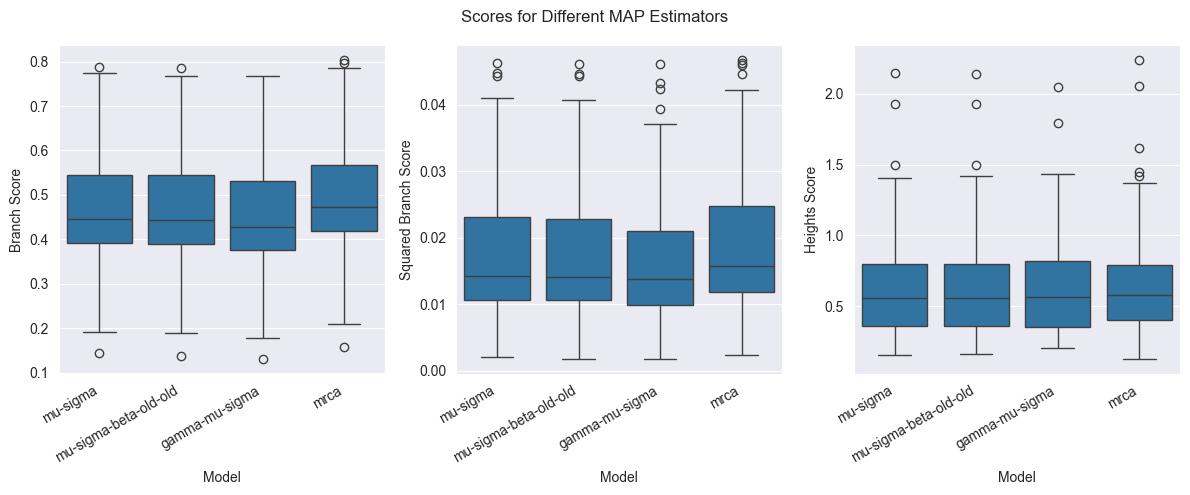

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

sns.boxplot(x="model", y="rbs", data=scores_dict, ax=axs[0])
sns.boxplot(x="model", y="srbs", data=scores_dict, ax=axs[1])
sns.boxplot(x="model", y="hs", data=scores_dict, ax=axs[2])


axs[0].set_xlabel("Model")
axs[1].set_xlabel("Model")
axs[2].set_xlabel("Model")

axs[0].set_ylabel("Branch Score")
axs[1].set_ylabel("Squared Branch Score")
axs[2].set_ylabel("Heights Score")

axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=30, ha='right')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=30, ha='right')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Scores for Different MAP Estimators")
plt.tight_layout()

In [51]:
df_rbs_wins = df_scores.sort_values("rbs").drop_duplicates(["dataset"])
df_srbs_wins = df_scores.sort_values("srbs").drop_duplicates(["dataset"])
df_hs_wins = df_scores.sort_values("hs").drop_duplicates(["dataset"])

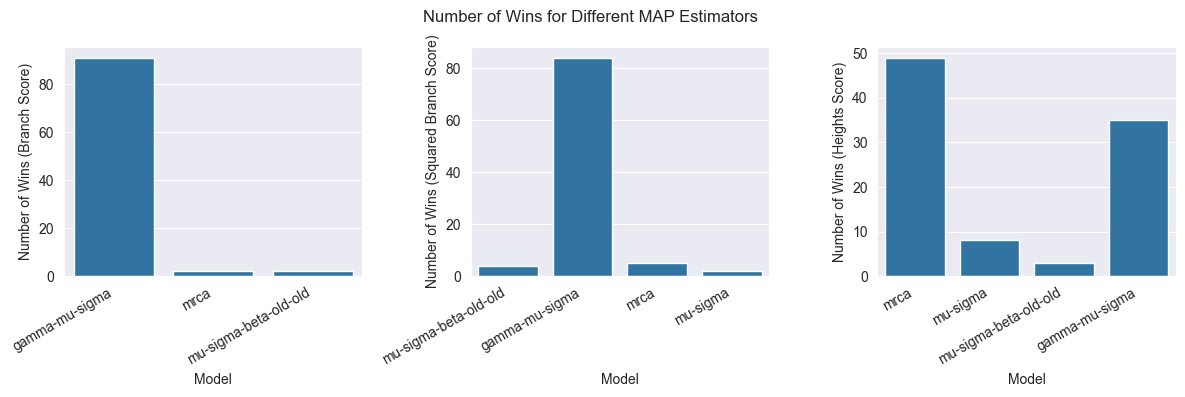

In [58]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

sns.countplot(data=df_rbs_wins, x="model", ax=axs[0])
sns.countplot(data=df_srbs_wins, x="model", ax=axs[1])
sns.countplot(data=df_hs_wins, x="model", ax=axs[2])

axs[0].set_xlabel("Model")
axs[1].set_xlabel("Model")
axs[2].set_xlabel("Model")

axs[0].set_ylabel("Number of Wins (Branch Score)")
axs[1].set_ylabel("Number of Wins (Squared Branch Score)")
axs[2].set_ylabel("Number of Wins (Heights Score)")

axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=30, ha='right')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=30, ha='right')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Number of Wins for Different MAP Estimators")
plt.tight_layout()

In [53]:
df_scores.sort_values("hs").drop_duplicates(["dataset"])

,model,dataset,rbs,srbs,hs
291,mrca,yule-10-75,0.466886,0.012557,0.126810
56,mrca,yule-10-62,0.209296,0.002542,0.147737
267,mu-sigma,yule-10-33,0.388661,0.010240,0.153637
79,mrca,yule-10-88,0.325001,0.007887,0.164847
25,mrca,yule-10-30,0.409375,0.010055,0.186798
...,...,...,...,...,...
74,gamma-mu-sigma,yule-10-89,0.484177,0.021026,1.191064
195,gamma-mu-sigma,yule-10-8,0.491713,0.023063,1.343840
177,mrca,yule-10-54,0.783125,0.046704,1.368510
126,gamma-mu-sigma,yule-10-57,0.621253,0.036384,1.794077


<Axes: >

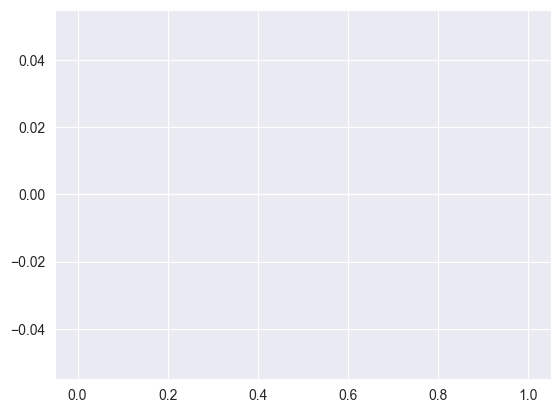

In [54]:
df_scores[df_scores.model == "srbs"]["rbs"].hist()